#Oil predictive maintenance
We want to predict the behavior of a pipe cooler.

##Configuration
### Package import

First, those packages that are going to be needed are imported.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import pickle as pkl 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn import manifold
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.python.keras import utils
from azureml.core import Experiment

In [0]:
%run "/Shared/config/Config"

##Dataset

The dataset to be used throughout this demo can be obtained through the following [link] (https://archive.ics.uci.edu/ml/datasets/Condition+monitoring+of+hydraulic+systems#) .

This data was obtained experimentally with a hydraulic test platform. This test platform consists of a primary working circuit and a secondary cooling-filtration circuit, which are connected through the oil tank. The system cyclically repeats constant charge cycles, which last for 60 seconds, and measures process values ​​such as pressures, volume flows, and temperatures, while the condition of four hydraulic components (cooler, valve, pump, and accumulator) it varies quantitatively.
Since we want to predict the behavior of the refrigerator system, we will only keep the data related to the temperature sensors (`` TS1.txt``, `` TS2.txt``, `` TS3.txt`` and `` TS4. txt``), these have been measured with a frequency of 1Hz, so there are a total of 60 observations for each cycle.

Along with the measurement data set, there is also the one for the different values ​​of the four hydraulic components. In this case, we are only interested in the cooling system, which is the one whose behavior we want to predict. These values ​​are:
- Next to total failure
- Reduced efficiency
- Total efficiency

###Reading data from DBFS

In [0]:
def read_data_from_dbfs(mount_path, filename):
  return pd.read_csv(f'/dbfs{mount_path}{filename}', sep='\t', header=None)

def append_dataframes(dataframes: list):
  df = pd.DataFrame()
  for dataframe in dataframes:
    df = df.append(dataframe)
  return df

Obtaining both the data set (`` sensors_data``) and the value of the different components (`` label``), which is the target to predict.

In [0]:
filenames = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']
mount_path = "/mnt/oildata/"

sensors_data = {filename:read_data_from_dbfs(mount_path, filename) for filename in filenames}
label = read_data_from_dbfs(mount_path, 'profile.txt')
refrigerator_labels = label[0]

#Exploratory analysis

##Descriptive analysis

In [0]:
for filename, data in sensors_data.items():
  print(filename)
  print(data.shape)
  print(data.describe())

TS1.txt
(2205, 60)
 0 1 ... 58 59
count 2205.000000 2205.000000 ... 2205.000000 2205.000000
mean 45.511420 45.460717 ... 45.531347 45.527454
std 8.025131 8.025665 ... 8.018769 8.022338
min 35.398000 35.320000 ... 35.402000 35.395000
25% 36.312000 36.238000 ... 36.320000 36.316000
50% 44.863000 44.855000 ... 44.937000 44.930000
75% 54.238000 54.148000 ... 54.242000 54.238000
max 58.039000 57.953000 ... 57.973000 58.023000

[8 rows x 60 columns]
TS2.txt
(2205, 60)
 0 1 ... 58 59
count 2205.000000 2205.000000 ... 2205.000000 2205.000000
mean 50.456266 50.446519 ... 50.447910 50.449173
std 7.445679 7.445094 ... 7.438152 7.441991
min 40.840000 40.891000 ... 40.879000 40.891000
25% 41.914000 41.910000 ... 41.902000 41.902000
50% 49.832000 49.816000 ... 49.828000 49.828000
75% 58.707000 58.695000 ... 58.695000 58.695000
max 62.094000 62.039000 ... 62.094000 62.094000

[8 rows x 60 columns]
TS3.txt
(2205, 60)
 0 1 ... 58 59
count 2205.000000 2205.000000 ... 2205.000000 2205.000000
mean 47.635995 47.639259 ... 47.629629 47.632103
std 7.481373 7.481595 ... 7.479501 7.481029
min 38.176000 38.172000 ... 38.160000 38.160000
25% 39.086000 39.086000 ... 39.086000 39.086000
50% 47.012000 47.020000 ... 47.008000 47.008000
75% 55.660000 55.668000 ... 55.656000 55.656000
max 59.484000 59.516000 ... 59.492000 59.488000

[8 rows x 60 columns]
TS4.txt
(2205, 60)
 0 1 ... 58 59
count 2205.000000 2205.000000 ... 2205.000000 2205.000000
mean 40.712106 40.704794 ... 40.749975 40.721770
std 8.108900 8.104933 ... 8.113798 8.112509
min 30.355000 30.363000 ... 30.383000 30.363000
25% 31.254000 31.254000 ... 31.281000 31.254000
50% 40.410000 40.410000 ... 40.441000 40.414000
75% 49.340000 49.336000 ... 49.422000 49.406000
max 53.043000 53.055000 ... 53.070000 53.043000

[8 rows x 60 columns]

##Graphical analysis

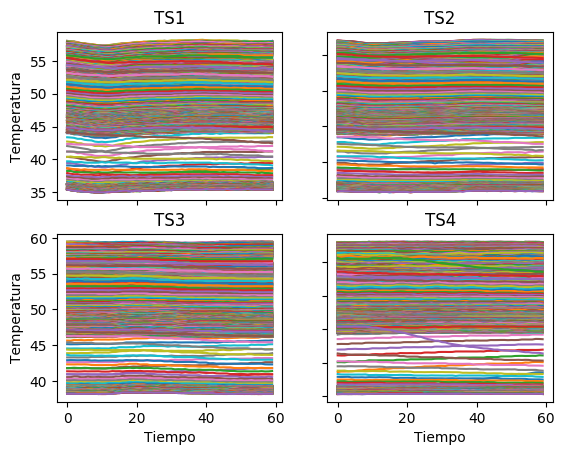

In [0]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sensors_data['TS1.txt'].T)
axs[0, 0].set_title('TS1')
axs[0, 1].plot(sensors_data['TS2.txt'].T)
axs[0, 1].set_title('TS2')
axs[1, 0].plot(sensors_data['TS3.txt'].T)
axs[1, 0].set_title('TS3')
axs[1, 1].plot(sensors_data['TS4.txt'].T)
axs[1, 1].set_title('TS4')

for ax in axs.flat:
    ax.set(xlabel='Tiempo', ylabel='Temperatura')

for ax in axs.flat:
    ax.label_outer()
    
display(fig.show())

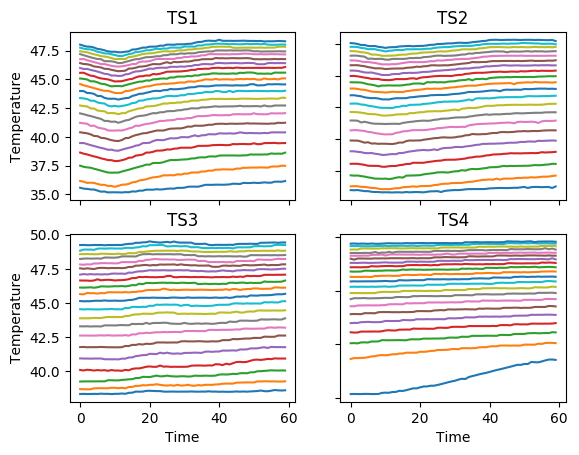

In [0]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(sensors_data['TS1.txt'].loc[0:20,:].T)
axs[0, 0].set_title('TS1')
axs[0, 1].plot(sensors_data['TS2.txt'].loc[0:20,:].T)
axs[0, 1].set_title('TS2')
axs[1, 0].plot(sensors_data['TS3.txt'].loc[0:20,:].T)
axs[1, 0].set_title('TS3')
axs[1, 1].plot(sensors_data['TS4.txt'].loc[0:20,:].T)
axs[1, 1].set_title('TS4')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Temperature')

for ax in axs.flat:
    ax.label_outer()
    
display(fig.show())

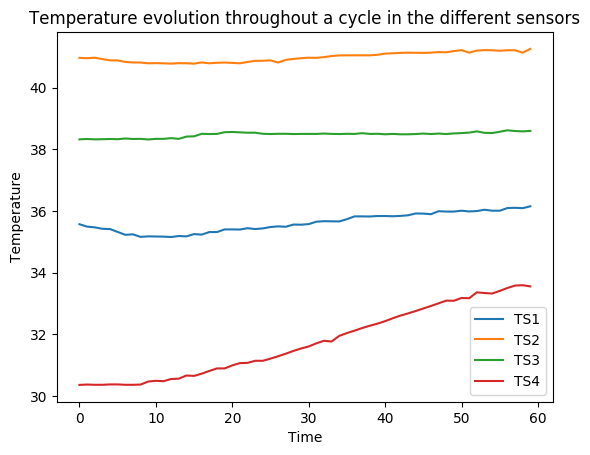

In [0]:
title = 'Temperature evolution throughout a cycle in the different sensors'
ylabel = 'Temperature'
xlabel = 'Time'
legend = ['TS1','TS2','TS3','TS4']

plt.subplot()
plt.plot(sensors_data['TS1.txt'].loc[0,:].T)
plt.plot(sensors_data['TS2.txt'].loc[0,:].T)
plt.plot(sensors_data['TS3.txt'].loc[0,:].T)
plt.plot(sensors_data['TS4.txt'].loc[0,:].T)

plt.title(title)
plt.ylabel(ylabel)
plt.xlabel(xlabel)
plt.legend(legend)
display(plt.show())

In [0]:
label_dict = refrigerator_labels.value_counts().to_dict()
label_dict['Total efficiency'] = label_dict.pop(100)
label_dict['Next to total failure'] = label_dict.pop(3)
label_dict['Reduced efficiency'] = label_dict.pop(20)

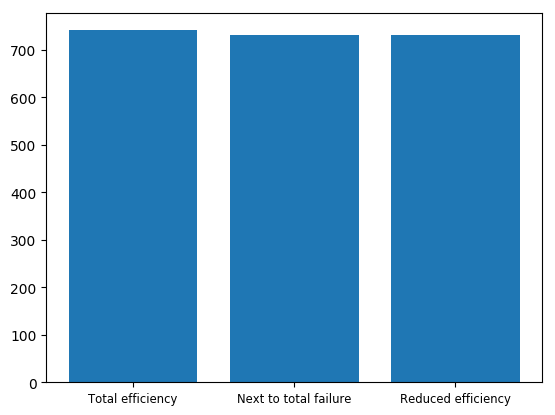

In [0]:
label_names = pd.Series(label_dict)
plt.bar(range(len(label_names)), label_names.values, align='center')
plt.xticks(range(len(label_names)), label_names.index.values, size='small')
display(plt.show())

Creation of a DataFrame with all the data.

In [0]:
df = append_dataframes(sensors_data.values())
df.to_csv(f'/dbfs{mount_path}pumps_temperature.csv', sep='\t', header=True)
display(df)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
35.57,35.492,35.469,35.422,35.414,35.32,35.227,35.242,35.16,35.176,35.172,35.168,35.156,35.187,35.176,35.25,35.234,35.316,35.316,35.402,35.402,35.398,35.441,35.414,35.434,35.48,35.5,35.488,35.559,35.555,35.574,35.652,35.668,35.664,35.66,35.734,35.824,35.824,35.82,35.836,35.836,35.828,35.84,35.859,35.918,35.914,35.895,35.992,35.98,35.98,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.09,36.152
36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.82,35.727,35.727,35.648,35.734,35.828,35.848,35.902,36.035,36.078,36.199,36.246,36.301,36.398,36.473,36.5,36.555,36.652,36.645,36.664,36.652,36.738,36.715,36.797,36.797,36.891,36.902,36.898,36.984,36.984,37.062,37.051,37.145,37.141,37.172,37.164,37.164,37.152,37.238,37.234,37.305,37.305,37.324,37.328,37.324,37.34,37.332,37.316,37.41,37.418,37.422,37.488,37.477
37.488,37.391,37.34,37.312,37.223,37.145,37.059,36.973,36.898,36.879,36.887,36.887,36.98,37.059,37.137,37.23,37.316,37.398,37.477,37.582,37.578,37.723,37.73,37.73,37.797,37.898,37.98,37.977,37.984,38.016,38.031,38.047,38.117,38.125,38.195,38.219,38.207,38.289,38.301,38.281,38.367,38.379,38.379,38.379,38.379,38.375,38.367,38.391,38.391,38.469,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,37.887,37.902,37.965,38.047,38.18,38.203,38.367,38.406,38.457,38.629,38.633,38.699,38.801,38.801,38.828,38.902,38.895,38.969,38.988,39.055,39.055,39.055,39.055,39.121,39.215,39.215,39.219,39.227,39.273,39.285,39.293,39.293,39.273,39.285,39.375,39.359,39.375,39.379,39.367,39.363,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,38.809,38.789,38.883,38.965,39.047,39.121,39.234,39.281,39.453,39.461,39.488,39.633,39.723,39.719,39.711,39.801,39.879,39.867,39.883,39.973,39.973,39.961,40.047,40.133,40.047,40.133,40.145,40.23,40.219,40.219,40.305,40.297,40.285,40.309,40.281,40.309,40.391,40.348,40.32,40.336,40.324,40.32,40.312,40.34,40.32,40.387,40.391,40.391,40.387,40.391
40.398,40.352,40.309,40.219,40.078,40.059,39.914,39.887,39.805,39.711,39.656,39.633,39.719,39.887,39.906,40.047,40.152,40.219,40.305,40.324,40.402,40.473,40.551,40.551,40.551,40.637,40.711,40.719,40.738,40.734,40.801,40.898,40.883,40.977,40.965,40.965,41.0,41.051,41.051,41.125,41.137,41.145,41.121,41.145,41.145,41.133,41.148,41.148,41.184,41.16,41.163999999999994,41.156000000000006,41.148,41.148,41.137,41.16,41.16,41.227,41.211000000000006,41.227
41.223,41.176,41.145,40.957,40.977,40.816,40.746,40.699,40.562,40.539,40.547,40.562,40.551,40.629,40.734,40.805,40.973,40.957,41.051,41.125,41.156000000000006,41.223,41.293,41.391000000000005,41.383,41.43,41.449,41.468999999999994,41.559,41.562,41.57,41.637,41.637,41.742,41.809,41.801,41.816,41.836000000000006,41.891000000000005,41.891000000000005,41.879,41.879,41.891000000000005,41.883,41.961000000000006,41.973,41.968999999999994,41.961000000000006,41.968999999999994,41.961000000000006,42.055,41.973,41.968999999999994,41.961000000000006,41.973,42.055,42.038999999999994,42.043,42.043,42.062
42.043,41.973,41.883,41.812,41.73,41.641000000000005,41.562,41.387,41.383,41.309,41.332,41.227,41.316,41.426,41.477,41.608999999999995,41.742,41.816,41.84,41.891000000000005,41.983999999999995,42.062,42.055,42.141000000000005,42.145,42.227,42.242,42.242,42.309,42.32,42.387,42.41,42.488,42.477,42.48,42.57,42.562,42.586000000000006,42.625,42.66,42.625,42.641000000000005,42.648,42.652,42.652,42.668,42.703,42.66,42.668,42.663999999999994,42.676,42.676,42.641000000000005,42.733999999999995,42.66,42.66,42.73,42.727,42.73,42.73
42.73,42.676,42.648,42.477,42.465,42.293,42.25,42.227,42.055,42.074,42.055,41.977,42.062,42.066,42.227,42.305,42.398,42.48,42.504,42.648,42.66,42.68,42.73,42.809,42.902,42.895,42.945,4

#Data preprocessing

In [0]:
def scale(df):
    return (df - df.mean(axis=0))/df.std(axis=0)
  
df = df.apply(scale)

Transformation of the data to be passed as input to the convolutional network.

In [0]:
df = df.sort_index().values.reshape(-1,4,60).transpose(0,2,1)

_label_ encode

In [0]:
label = utils.to_categorical(refrigerator_labels.factorize()[0])
label.shape

Out[17]: (2205, 3)

Obtaining the training and test sets:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df, label, random_state = 42,test_size=0.2)

##Model construction: Conv1D CNN

In [0]:
def conv1D_architecture(filter_1, kernel, filter_2, dropout, x, y, num_classes = 3):
    model = Sequential()
    model.add(Conv1D(filter_1, kernel, activation='relu', input_shape=(x, y)))
    model.add(Conv1D(filter_1, kernel, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(filter_2, kernel, activation='relu'))
    model.add(Conv1D(filter_2, kernel, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    return model

To be able to use this model in our embedded device, it will have to be converted to a TF Lite model. The function used to achieve this is shown below:

In [0]:
def model_2_tflite_conversion(model_filename, tflite_filename):
    converter = tf.lite.TFLiteConverter.from_keras_model_file(model_filename)
    tflite_model = converter.convert()
    with open(tflite_filename, "wb") as f:
      f.write(tflite_model)
    return tflite_model

##Model training with Azure ML Workspace

Model parameters:

In [0]:
num_epochs = range(6,10,2)
filters_1 = range(100,200,50)
filters_2 = range(160,260,50)
kernel_size = range(6,10,2)
dropouts = [0,0.1,0.2,0.3,0.4,0.5]
BATCH_SIZE = 16

num_sensors = 4
TIME_PERIODS = 60
old_accuracy = 0

Performing a _grid search_ in order to find that combination of parameters that result in a better _accuracy_ on the test set of our model.

In [0]:
experiment_name = 'vcoffee_oilmaintenance_exp'
exp = Experiment(workspace=ws, name=experiment_name)
root_run = exp.start_logging(snapshot_directory=None)

for epoch in num_epochs:
  for filter_1, filter_2 in zip(filters_1, filters_2):
    for kernel in kernel_size:
      for dropout in dropouts:
        model_name = f'conv1D_{filter_1}_{filter_2}_{kernel}_{dropout}_{epoch}'
        print(model_name)
        with root_run.child_run(f"params: {model_name}") as run:
          run.log('Dropout', dropout)
          run.log('Kernel size', kernel)
          run.log('Filter 1', filter_1)
          run.log('Filter 2', filter_2)
          run.log('Epoch', epoch)
          
          model = conv1D_architecture(filter_1, kernel, filter_2, dropout, TIME_PERIODS, num_sensors)
          model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
          
          history = model.fit(X_train,
                              y_train,
                              batch_size=BATCH_SIZE,
                              epochs=epoch,
                              validation_split=0.2,
                              verbose=1)
                                
          run.log_list('Accuracy', history.history['acc'])
          run.log_list('Validation Accuracy',history.history['val_acc'])
          run.log_list('Loss', history.history['loss'])
          run.log_list('Validation loss',history.history['val_loss'])
                              
          accuracy = model.evaluate(X_test, y_test, verbose=1)[1]
          run.log('Testing Accurracy', accuracy)
          
          model_filename = f'{model_name}.h5'                            
          model.save(model_filename)
            
          tflite_filename = f'{model_name}.tflite'
          tflite_model = model_2_tflite_conversion(model_filename, tflite_filename)

          run.upload_file(f'outputs/{tflite_filename}',tflite_filename)
          run.register_model(model_name=tflite_filename, model_path=f'outputs/{tflite_filename}', tags = {'dropout': str(dropout), 'epochs': str(epoch), \
                                                                                                'kernel': str(kernel), 'accuracy':  str(accuracy),\
                                                                                                'filter_1': str(filter_1), 'filter_2': str(filter_2)})                            
          if accuracy > old_accuracy:
            best_tflite_model = tflite_model
            best_history = history
            best_accuracy = accuracy
            best_model_name = model_name
            best_model = model
            best_dropout = dropout
            best_kernel = kernel
            best_filter_1 = filter_1
            best_filter_2 = filter_2
            best_epoch = epoch
            old_accuracy = accuracy    

conv1D_100_160_6_0_6
WARNING:tensorflow:From /databricks/python/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1411 samples, validate on 353 samples
Epoch 1/6
 16/1411 [..............................] - ETA: 42s - loss: 1.1067 - acc: 0.1250 64/1411 [>.............................] - ETA: 12s - loss: 0.7944 - acc: 0.5469 112/1411 [=>............................] - ETA: 7s - loss: 0.6231 - acc: 0.6518  160/1411 [==>...........................] - ETA: 5s - loss: 0.5515 - acc: 0.7063 208/1411 [===>..........................] - ETA: 4s - loss: 0.4793 - acc: 0.7500 256/1411 [====>.........................] - ETA: 3s - loss: 0.4207 - acc: 0.7891 304/1411 [=====>........................] - ETA: 3s - loss: 0.4051 - acc: 0.8092 368/1411 [======>.......................] - ETA: 2s - loss: 0.3478 - acc: 0.8397 416/1411 [=======>......................] - ETA: 2s - loss: 0.3127 - acc: 0.8582 464/1411 [========>.....................] - ETA: 2s - loss: 0.2963 - acc: 0.8685 512/1411 [=========>....................] - ETA: 1s - loss: 0.2713 - acc: 0.8809 560/1411 [==========>...................] - ETA: 1s - loss: 0.2497 - acc: 0.8911 624/1411 [============>.................] - ETA: 1s - loss: 0.2327 - acc: 0.8990 672/1411 [=============>................] - ETA: 1s - loss: 0.2314 - acc: 0.9018 720/1411 [==============>...............] - ETA: 1s - loss: 0.2165 - acc: 0.9083 784/1411 [===============>..............] - ETA: 1s - loss: 0.2285 - acc: 0.9120 832/1411 [================>.............] - ETA: 1s - loss: 0.2231 - acc: 0.9147 896/1411 [==================>...........] - ETA: 0s - loss: 0.2155 - acc: 0.9185 944/1411 [===================>..........] - ETA: 0s - loss: 0.2123 - acc: 0.92161008/1411 [====================>.........] - ETA: 0s - loss: 0.2006 - acc: 0.92661072/1411 [=====================>........] - ETA: 0s - loss: 0.2004 - acc: 0.92721136/1411 [=======================>......] - ETA: 0s - loss: 0.1986 - acc: 0.9296

Recording the best model in the main run of the experiment

In [0]:
with open(f'{best_model_name}.tflite', "wb") as f:
  f.write(best_tflite_model)
print(best_model.summary())
root_run.log('Dropout', best_dropout)
root_run.log('Kernel size', best_kernel)
root_run.log('Filter 1', best_filter_1)
root_run.log('Filter 2', best_filter_2)
root_run.log('Epoch', best_epoch)
root_run.log_list('Accuracy', best_history.history['acc'])
root_run.log_list('Validation Accuracy', best_history.history['val_acc'])
root_run.log_list('Loss', best_history.history['loss'])
root_run.log_list('Validation loss', best_history.history['val_loss'])

root_run.upload_file(f'outputs/best_conv1D.tflite',f'{best_model_name}.tflite')
root_run.register_model(model_name=f'best_conv1D.tflite', model_path=f'outputs/best_conv1D.tflite', tags = {'dropout': str(best_dropout), \
                                                                                                   'epochs': str(best_epoch), \
                                                                                                   'kernel': str(best_kernel),\
                                                                                                   'accuracy': str(best_accuracy), \
                                                                                                   'filter_1': str(best_filter_1), \
                                                                                                   'filter_2': str(best_filter_2), \
                                                                                                   'model_type':'1DCNN'})

Model: "sequential"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
conv1d (Conv1D) (None, 55, 100) 2500 
_________________________________________________________________
conv1d_1 (Conv1D) (None, 50, 100) 60100 
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 100) 0 
_________________________________________________________________
conv1d_2 (Conv1D) (None, 11, 160) 96160 
_________________________________________________________________
conv1d_3 (Conv1D) (None, 6, 160) 153760 
_________________________________________________________________
global_average_pooling1d (Gl (None, 160) 0 
_________________________________________________________________
dropout (Dropout) (None, 160) 0 
_________________________________________________________________
dense (Dense) (None, 3) 483 
=================================================================
Total params: 313,003
Trainable params: 313,003
Non-trainable params: 0
_________________________________________________________________
None
Out[23]: Model(workspace=Workspace.create(name='MlWorkspace-IntelligentModules', subscription_id='a798a873-cd97-4a75-b6f5-636475d707a0', resource_group='IoT-IntelligentModules'), name=best_conv1D.tflite, id=best_conv1D.tflite:2, version=2, tags={'dropout': '0.1', 'epochs': '8', 'kernel': '6', 'accuracy': '0.99319726', 'filter_1': '100', 'filter_2': '160', 'model_type': '1DCNN'}, properties={})

Representation of the metrics obtained during training

In [0]:
def plot_train_metrics(train_history, x, y, xlabel, ylabel, title):
  fig_acc = plt.figure(figsize=(5, 5))
  plt.plot(train_history.history[x])
  plt.plot(train_history.history[y])
  plt.title(title)
  plt.ylabel(xlabel)
  plt.xlabel(ylabel)
  plt.legend(['train', 'test'], loc='upper left')
  return plt

def get_classification_report(X, y, model):
  return classification_report(np.where(y != 0)[1], model.predict_classes(X))

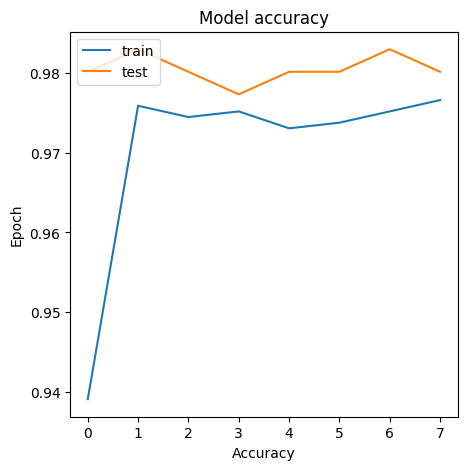

In [0]:
accuracy_plt = plot_train_metrics(best_history, 'acc', 'val_acc', 'Epoch', 'Accuracy', 'Model accuracy')
display(accuracy_plt.show())

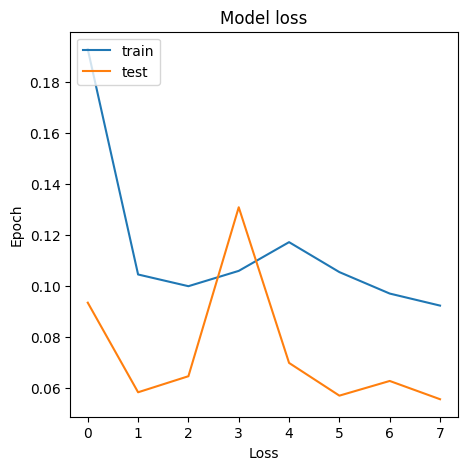

In [0]:
loss_plt = plot_train_metrics(best_history, 'loss', 'val_loss', 'Epoch', 'Loss', 'Model loss')
display(loss_plt.show())

Classification report

In [0]:
best_model = tf.keras.models.load_model(f'{best_model_name}.h5')
class_report = get_classification_report(X_test, y_test, best_model)
print(class_report)

precision recall f1-score support

 0 0.99 0.99 0.99 152
 1 0.99 0.99 0.99 135
 2 1.00 0.99 1.00 154

 micro avg 0.99 0.99 0.99 441
 macro avg 0.99 0.99 0.99 441
weighted avg 0.99 0.99 0.99 441

Obtaining predictions using the model converted to TF Lite.

In [0]:
interpreter = tf.lite.Interpreter(model_path=f'{best_model_name}.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

X_test = X_test.astype('float32')

y_predicted = np.zeros(y_test.shape[0])
for data_index in range(y_test.shape[0]):
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(X_test[data_index],axis=0))
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details[0]['index'])
    np.put(y_predicted,data_index,y_pred[0].argmax(axis=-1))
    
y_test_tf_lite= y_test.astype('int8')
y_predicted = y_predicted.astype('int8')

Representation of the confusion matrix

In [0]:
def plot_confusion_matrix(y_test, y_predicted, xlabel, ylabel, title):
  cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], y_predicted)
  fig_cm = plt.figure(figsize=(12, 12))
  ax = plt.subplot()
  sns.heatmap(cnf_matrix, annot=True, ax = ax,fmt='g');
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel) 
  ax.set_title(title) 
  return ax.figure

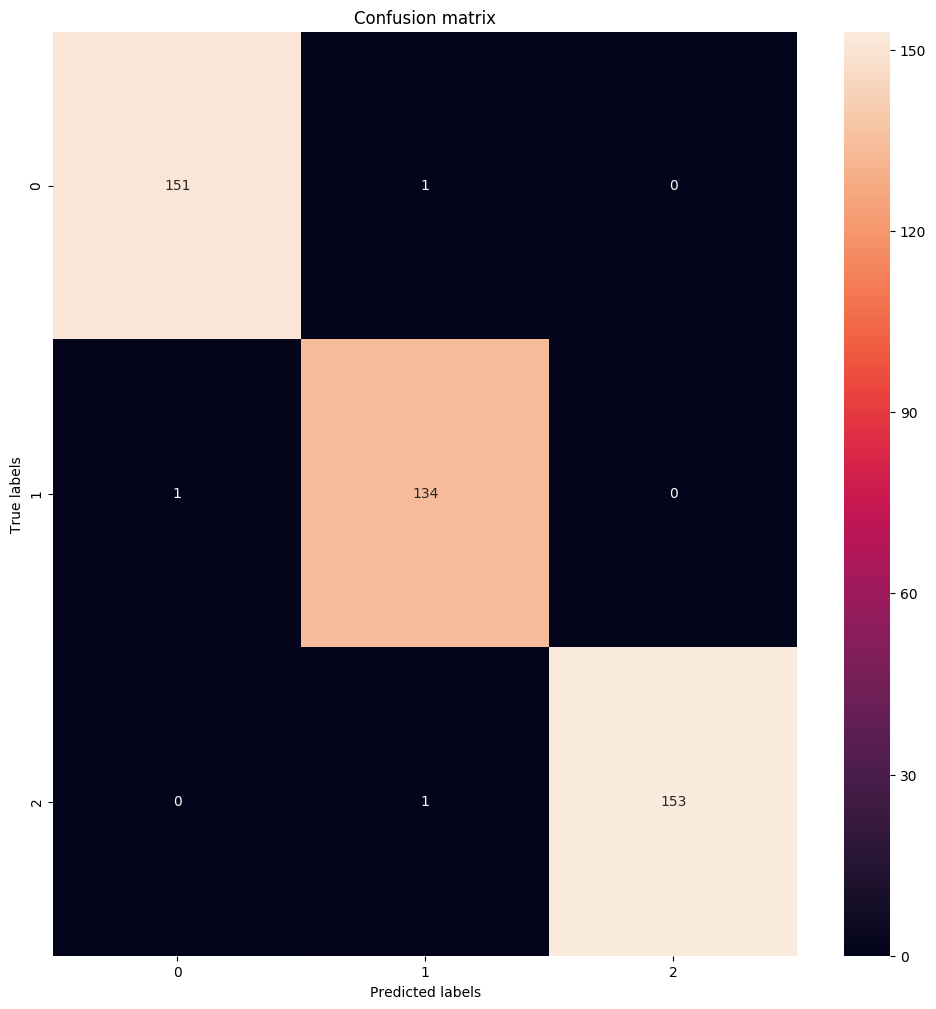

In [0]:
conf_matrix =  plot_confusion_matrix(y_test, y_predicted, 'Predicted labels', 'True labels', 'Confusion matrix')
display(conf_matrix)
root_run.log_image("Confusion matrix", plot=conf_matrix)

In [0]:
root_run.complete()